# Predictor Churn

# 0. Abstract

Se decide escoger un dataset para generar un predictor de churn, esto por la utilidad que tiene el entedimiento del churn en las empresas SaaS y aquellas que facturan por recurrencias.

El dataset en particular incluye datos sobre clientes del mundo de telecomunicaciones, y se seleccionó desde la plataforma kaggle y pudiendo ser consultando mediante el siguiente link: https://www.kaggle.com/datasets/rashadrmammadov/customer-churn-dataset

El objetivo general de esto es lograr generar un predictor de churn basado en las columnas entregadas, siendo la columna "Churn" la que vendría a ser nuestra variab le "Y" para el estudio. Ahora bien, lo primero que se debe realizar es un EDA sobre el dataset para entender la composición del mismo y revisar si permitirá a no cumplir con el objetivo. Seguido de esto se espera responder la hipótesis planteada para el proyecto.

Principales preguntas que se buscan responder en el EDA
- ¿Cómo es la composición del dataset?
- ¿Existen valores nulls o se debe realizar algún tratamiento especial sobre estos?
- ¿De las variables numéricas existen algunas con distribución normal?
- ¿Cómo se distribuyen las variables categóricas?
- ¿Las variables en estudio poseen valores outliers? De ser así ¿Qué podemos hacer con ellos?

Adicionalmente, se tiene como Hipótesis 0 la siguiente propusta:
- H0: Las variables de servicio (tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges) tienen un impacto significativo en la probabilidad de churn de los clientes.

- ¿Es posible demostrar la hipótesis en primera instancia?
- ¿Qué variables permitirían explicar de mejor manera el churn?
- ¿Cómo se encuentran correlacionadas estas variables?


# 1. Importar librerías

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# 2. Carga de Dataset y descripción inicial

In [36]:
url_churn = 'https://raw.githubusercontent.com/PGrimaldiP/proyecto_ds_final/main/customer_churn_data.csv'
df_churn = pd.read_csv(url_churn, encoding = 'unicode_escape')
df_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,CUST0000,Male,0,No,Yes,23,No,No phone service,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Bank transfer,49.85,1146.55,No
1,CUST0001,Female,0,Yes,No,43,No,No phone service,DSL,Yes,...,Yes,No,Yes,No,Month-to-month,No,Mailed check,100.70,4330.10,Yes
2,CUST0002,Male,1,No,No,51,Yes,No,DSL,No,...,Yes,Yes,No,No,One year,No,Electronic check,97.33,4963.83,Yes
3,CUST0003,Male,1,No,No,72,Yes,Yes,DSL,Yes,...,Yes,No,No,No,Month-to-month,No,Credit card,101.38,7299.36,No
4,CUST0004,Male,1,No,No,25,Yes,Yes,DSL,No,...,No,Yes,No,Yes,Month-to-month,No,Electronic check,52.22,1305.50,Yes


In [37]:
print(f'Dataset shape: {df_churn.shape}')

Dataset shape: (5880, 21)


In [38]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5880 non-null   object 
 1   gender            5880 non-null   object 
 2   SeniorCitizen     5880 non-null   int64  
 3   Partner           5880 non-null   object 
 4   Dependents        5880 non-null   object 
 5   tenure            5880 non-null   int64  
 6   PhoneService      5880 non-null   object 
 7   MultipleLines     5880 non-null   object 
 8   InternetService   5880 non-null   object 
 9   OnlineSecurity    5880 non-null   object 
 10  OnlineBackup      5880 non-null   object 
 11  DeviceProtection  5880 non-null   object 
 12  TechSupport       5880 non-null   object 
 13  StreamingTV       5880 non-null   object 
 14  StreamingMovies   5880 non-null   object 
 15  Contract          5880 non-null   object 
 16  PaperlessBilling  5880 non-null   object 


Inicialmente vemos un dataset pequeño [123.480 datos], pero con un nivel alto de completitud no teniendo datos nulos, lo que permite comenzar a explorar y trabajar de una manera más eficaz.

Adicionalmente vemos que existen mayoritariamente variables categóricas, lo que podría complejizar la comprobación de nuestras preguntas e hipótesis lo que indica que en el data wrangling del proyecto debemos indagar en la posibilidad de transformar estas variables a numéricas.

Describiremos las variables en cuestión que forman parte del proyecto

*   **customerID**: número identificador del cliente en cuestión
*   **gender**: género del cliente
*   **SeniorCitizen**: indica si el cliente es adulto mayor o no
*   **Partner**: indica si el cliente tiene parejo o no
*   **Dependents**: indica si el cliente tiene personas asociadas en su cuenta
*   **tenure**: indica la cantidad de meses que lleva o llevaba el cliente en la compañía
*   **PhoneService**: indica si el cliente tiene servicio telefónico o no
*   **MultipleLines**: indica si el cliente tiene más de 1 línea, si tiene 1 línea o si no tiene servicio
*   **InternetService**: indica si el cliente tiene servicio de internet o no
*   **OnlineSecurity**: indica si el cliente tiene servicio de seguridad online o no
*   **OnlineBackup**: indica si el cliente tiene servicio de respaldo online o no
*   **DeviceProtection**: indica si el cliente tiene servicio de protección de dispositivos o no
*   **TechSupport**: indica si el cliente tiene servicio técnico o no
*   **StreamingTV**: indica si el cliente tiene servicio de streaming de televisión o no
*   **StreamingMovies**: indica si el cliente tiene servicio de streaming de películas o no
*   **Contract**: indica el período de facturación del contrato del cliente
*   **PaperlessBilling**: indica si el cliente utiliza un servicio de pagos o no
*   **PaymentMethod**: indica el medio de pago del cliente
*   **MonthlyCharges**: indica la recurrencia o pago mensual del cliente
*   **TotalCharges**: indica el monto total que se le ha cobrado al cliente
*   **Churn**: indica si el cliente está churneado o no

In [39]:
# Generamos un análisis estadístico básico para las variables numéricas
print(df_churn.describe())

       SeniorCitizen       tenure  MonthlyCharges  TotalCharges
count    5880.000000  5880.000000     5880.000000   5880.000000
mean        0.500680    36.549150       70.157779   2566.813165
std         0.500042    20.909674       28.804615   1910.017743
min         0.000000     1.000000       20.000000     20.030000
25%         0.000000    18.000000       45.717500   1020.217500
50%         1.000000    37.000000       70.155000   2136.445000
75%         1.000000    55.000000       95.457500   3767.665000
max         1.000000    72.000000      119.990000   8589.600000


In [40]:
# Generamos un análisis estadístico básico para las variables categóricas
print(df_churn.describe(include='object'))

       customerID gender Partner Dependents PhoneService     MultipleLines  \
count        5880   5880    5880       5880         5880              5880   
unique       5880      2       2          2            2                 3   
top      CUST0000   Male     Yes         No          Yes  No phone service   
freq            1   2950    2995       3004         2941              2939   

       InternetService       OnlineSecurity         OnlineBackup  \
count             5880                 5880                 5880   
unique               3                    3                    3   
top                 No  No internet service  No internet service   
freq              2029                 2029                 2029   

           DeviceProtection          TechSupport          StreamingTV  \
count                  5880                 5880                 5880   
unique                    3                    3                    3   
top     No internet service  No internet service 

# 3. EDA

Ahora que estudiamos inicialmente el dataset procederemos al estudio de este mismo mediante el análisis exploratorio de datos, fase que nos permitirá entender en mayor profundidad las preguntas planteadas al comienzo.

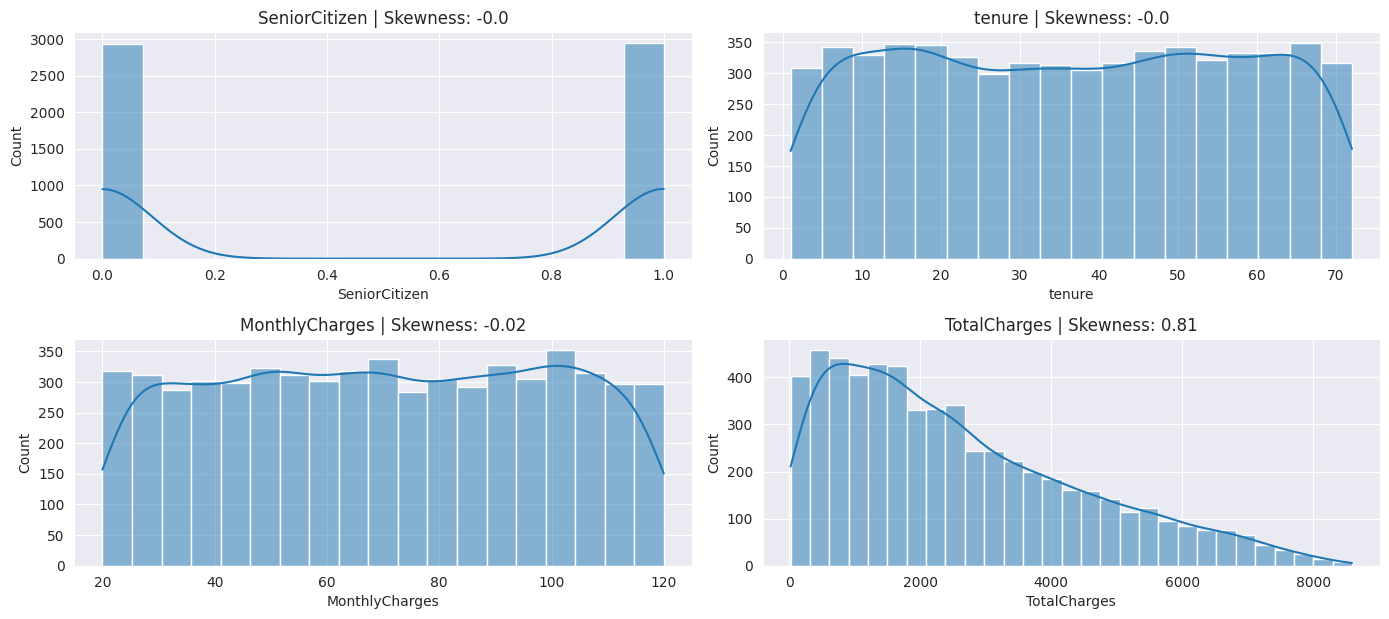

In [41]:
# Configuramos el estilo Seaborn
sns.set_style("darkgrid")

# Identificar columnas numéricas
numerical_columns = df_churn.select_dtypes(include=["int64", "float64"]).columns

# Graficamos la distribución para cada columna numércia
plt.figure(figsize=(14, len(numerical_columns) * 3))
for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 2, idx)
    sns.histplot(df_churn[feature], kde=True)
    plt.title(f"{feature} | Skewness: {round(df_churn[feature].skew(), 2)}")

plt.tight_layout()
plt.show()

Vemos que las variables numéricas del dataset se encuentran distribuido de manera similar, no encontramos sesgos relevantes en la mayoría de las variables estudiadas, salvo en TotalCharges que presenta un sesgo a la derecha. En el
resto de las variables numéricas no binarias, no se observan sesgos relevantes, sin embargo, no se observa la forma típica de una distribución normal como campaa de Gauss.

Ahora pasaremos a revisar la distribución de las variables del set utilizando gráficos tipo boxplot y scatterplot, aunque previamente revisaremos las medidas estadísticas básicas para tener una mirada general ahora que hemos transformado nuestras variables.

Debido a que gran parte de nuestras columnas provienen de variables categóricas que podríamos denominar binarias, estudiar estas en un boxplot carece de sentido, por lo que sólo se regirá este análisis para variables continuas

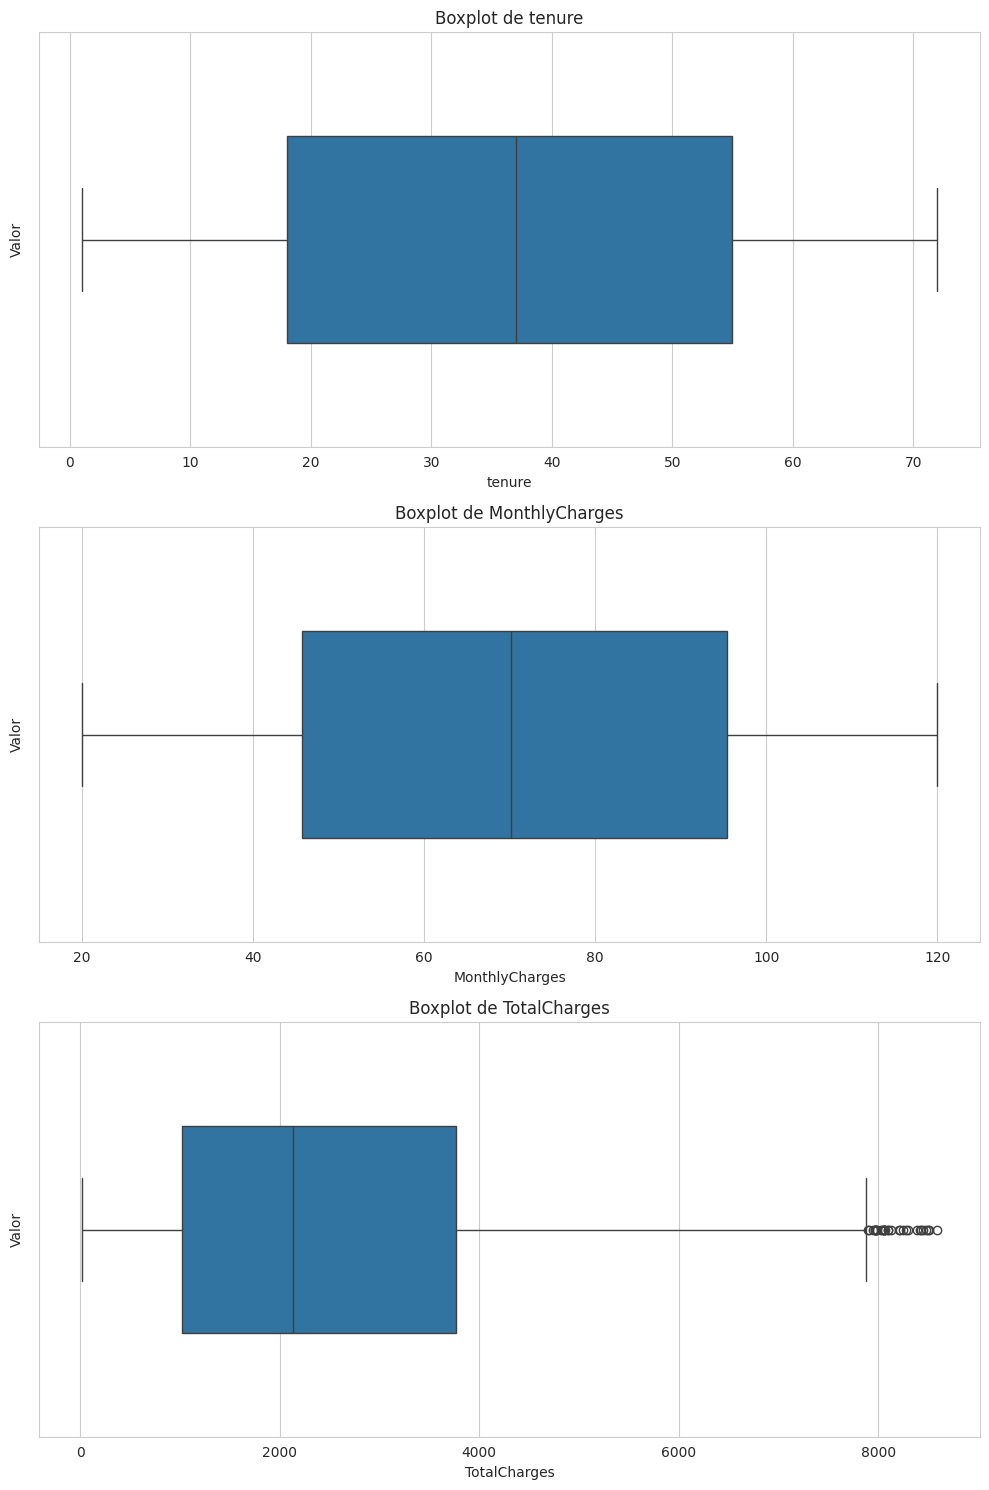

In [42]:
# Configuramos el estilo Seaborn
sns.set_style("whitegrid")

# Identificar columnas numéricas
numerical_columns = ['tenure', 'MonthlyCharges',	'TotalCharges']

# Graficamos un boxplot para cada columna numérica de forma individual
plt.figure(figsize=(10, len(numerical_columns) * 5))

for idx, feature in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns), 1, idx)
    sns.boxplot(x=df_churn[feature], width=0.5)
    plt.title(f"Boxplot de {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel("Valor")

plt.tight_layout()
plt.show()



Del análisis de boxplot podemos obtener que la variable TotalCharges tiene valores outliers, es decir que se encuentran sobre 1.5 RIC, esto era esperable por el comportamiento de la variable en los histogramas en donde observamos un sesgo a la derecha. Esto podría resultar intersante de observar en un análisis de mayor profundidad sobre los datos outliers.

In [43]:
# Calcular IQR
Q1 = df_churn['TotalCharges'].quantile(0.25)
Q3 = df_churn['TotalCharges'].quantile(0.75)
IQR = Q3 - Q1

# Identificar outliers
outliers_iqr = df_churn[(df_churn['TotalCharges'] < (Q1 - 1.5 * IQR)) | (df_churn['TotalCharges'] > (Q3 + 1.5 * IQR))]
print(outliers_iqr[['TotalCharges']])

      TotalCharges
83         7990.34
410        8498.16
650        8054.64
764        8419.18
1006       8390.16
1362       8478.00
1598       8026.04
1631       7977.09
1765       8589.60
1976       7948.21
2218       8213.80
2225       8099.91
2314       8053.20
2818       7965.63
3060       8242.50
3302       8041.00
3414       8292.80
3473       8057.32
3707       8099.22
3775       7966.97
3789       7961.94
4094       8279.31
4437       8121.60
4638       7894.98
4718       8202.63
4774       7980.48
4872       8053.68
5082       8505.09
5257       7902.96
5349       8449.20
5476       8430.54
5704       8064.89


In [44]:
print(outliers_iqr[['TotalCharges']].count())

TotalCharges    32
dtype: int64


Primero identificamos todos los outliers basados en el método IQR, es decir identificamos aquellos valores que se encuentran 1.5 veces sobre el RIC como fue mencionado anteriormnete. En este primer análisis podemos notar un número de outliers bajo con un total de 32 casos sobre un dataset de 5.880 filas, siendo un aproximado de 0.5% del total de los datos.

In [45]:
# Calcular el Z-Score
df_churn['TotalCharges_zscore'] = (df_churn['TotalCharges'] - df_churn['TotalCharges'].mean()) / df_churn['TotalCharges'].std()

# Identificar outliers
outliers_zscore = df_churn[np.abs(df_churn['TotalCharges_zscore']) > 3]
print(outliers_zscore[['TotalCharges', 'TotalCharges_zscore']])

      TotalCharges  TotalCharges_zscore
410        8498.16             3.105388
764        8419.18             3.064038
1006       8390.16             3.048844
1362       8478.00             3.094833
1765       8589.60             3.153262
5082       8505.09             3.109017
5349       8449.20             3.079755
5476       8430.54             3.069986


Al utilizar el método Z-Score identificamos todos aquellos valores sobre 3 desviaciones estándar respecto a la media, ahora identificamos estos 8 valores que se escapan bastante de la media observada, por lo que podrían estar afectando a los valores de este mismo.

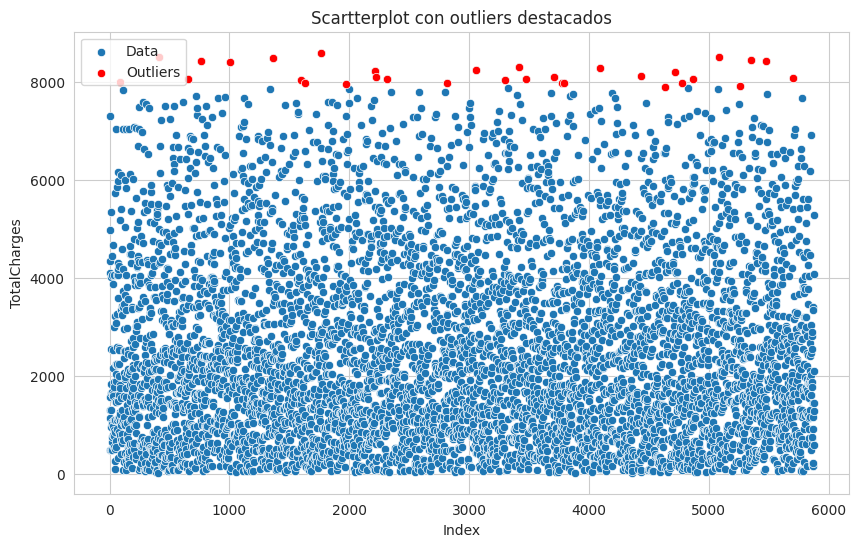

In [46]:
# Scartterplot con outliers destacados
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_churn.index, y=df_churn['TotalCharges'], label='Data')
sns.scatterplot(x=outliers_iqr.index, y=outliers_iqr['TotalCharges'], color='red', label='Outliers')
plt.title("Scartterplot con outliers destacados")
plt.xlabel("Index")
plt.ylabel("TotalCharges")
plt.legend()
plt.show()

En el gráfico podemos observar complementariamente al boxplot dónde se ubican los outliers y vemos que no se encuentran tan alejados respecto al valor del método IQR lo que es bastante interesante. Sobre los outliers se decide no eliminarlos del dataset principalmente por lo que representa la variable, que es cobros acumulados, es de esperar que en una compañía de telecomunicaciones algunos usuarios tengan mayores cobros acumulados que otros, pues muchos permanencen con la misma compañía durante años.

Complementaremos lo anterior con un scatterplot entre variables tenure y TotalCharges, lo que probablemente indique un aumento sostenido del TotalCharge en base al aumento de los meses de tenure.

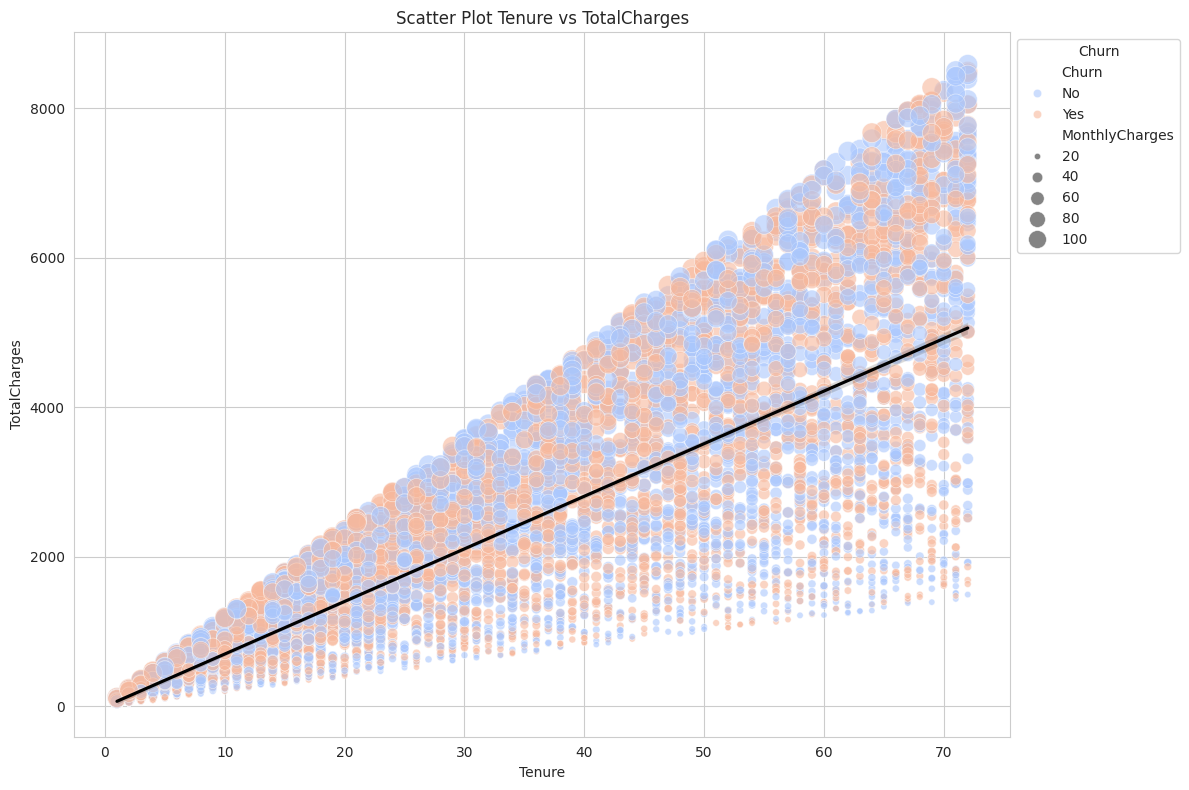

In [47]:
# Configuramos el estilo Seaborn
sns.set_style("whitegrid")

# Creamos el scatterplot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    data=df_churn,
    x='tenure',
    y='TotalCharges',
    hue='Churn',
    palette='coolwarm',
    size='MonthlyCharges',
    sizes=(20, 200),
    alpha=0.6
)

# Añadimos la línea de tendencia
sns.regplot(
    data=df_churn,
    x='tenure',
    y='TotalCharges',
    scatter=False,
    color='black',
    line_kws={'label':"Linea de tendencia"}
)

# Configuramos la cuadrícula
scatter_plot.grid(True)

# Añadimos título y etiquetas
plt.title("Scatter Plot Tenure vs TotalCharges")
plt.xlabel("Tenure")
plt.ylabel("TotalCharges")

# Incluímos la leyenda
plt.legend(title='Churn', loc='upper left', bbox_to_anchor=(1, 1))

# Mostramos gráfico
plt.tight_layout()
plt.show()

Como se mencionó anteriormente vemos una tendencia bastante líneal en la gráfica, teniendo un aumento sostenido en base aumentan los meses. Las desviaciones respecto a la línea de tendencia son más fáciles de observar utilizando MonthCharges para el tamaño de los puntos, pues podemos notar que más alejada de manera positiva de la curva los puntos son mayores y más alejado hacia abajo de la curva los puntos son menores.

Estudiaremos las variables categóricas en este momento, cabe destacar que del estudio previo del dataframe notamos que existe una cantidad amplia de variables binarias no numéricas

<ipython-input-48-c4a1a31d7993>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=['lightcoral', 'skyblue'], ax=axes[i])
<ipython-input-48-c4a1a31d7993>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=['lightcoral', 'skyblue'], ax=axes[i])
<ipython-input-48-c4a1a31d7993>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=['lightcoral', 'skyblue'], ax=axes[i])
<ipython-input-48-c4a1a31d7993>:16: FutureWarning: 

Passing 

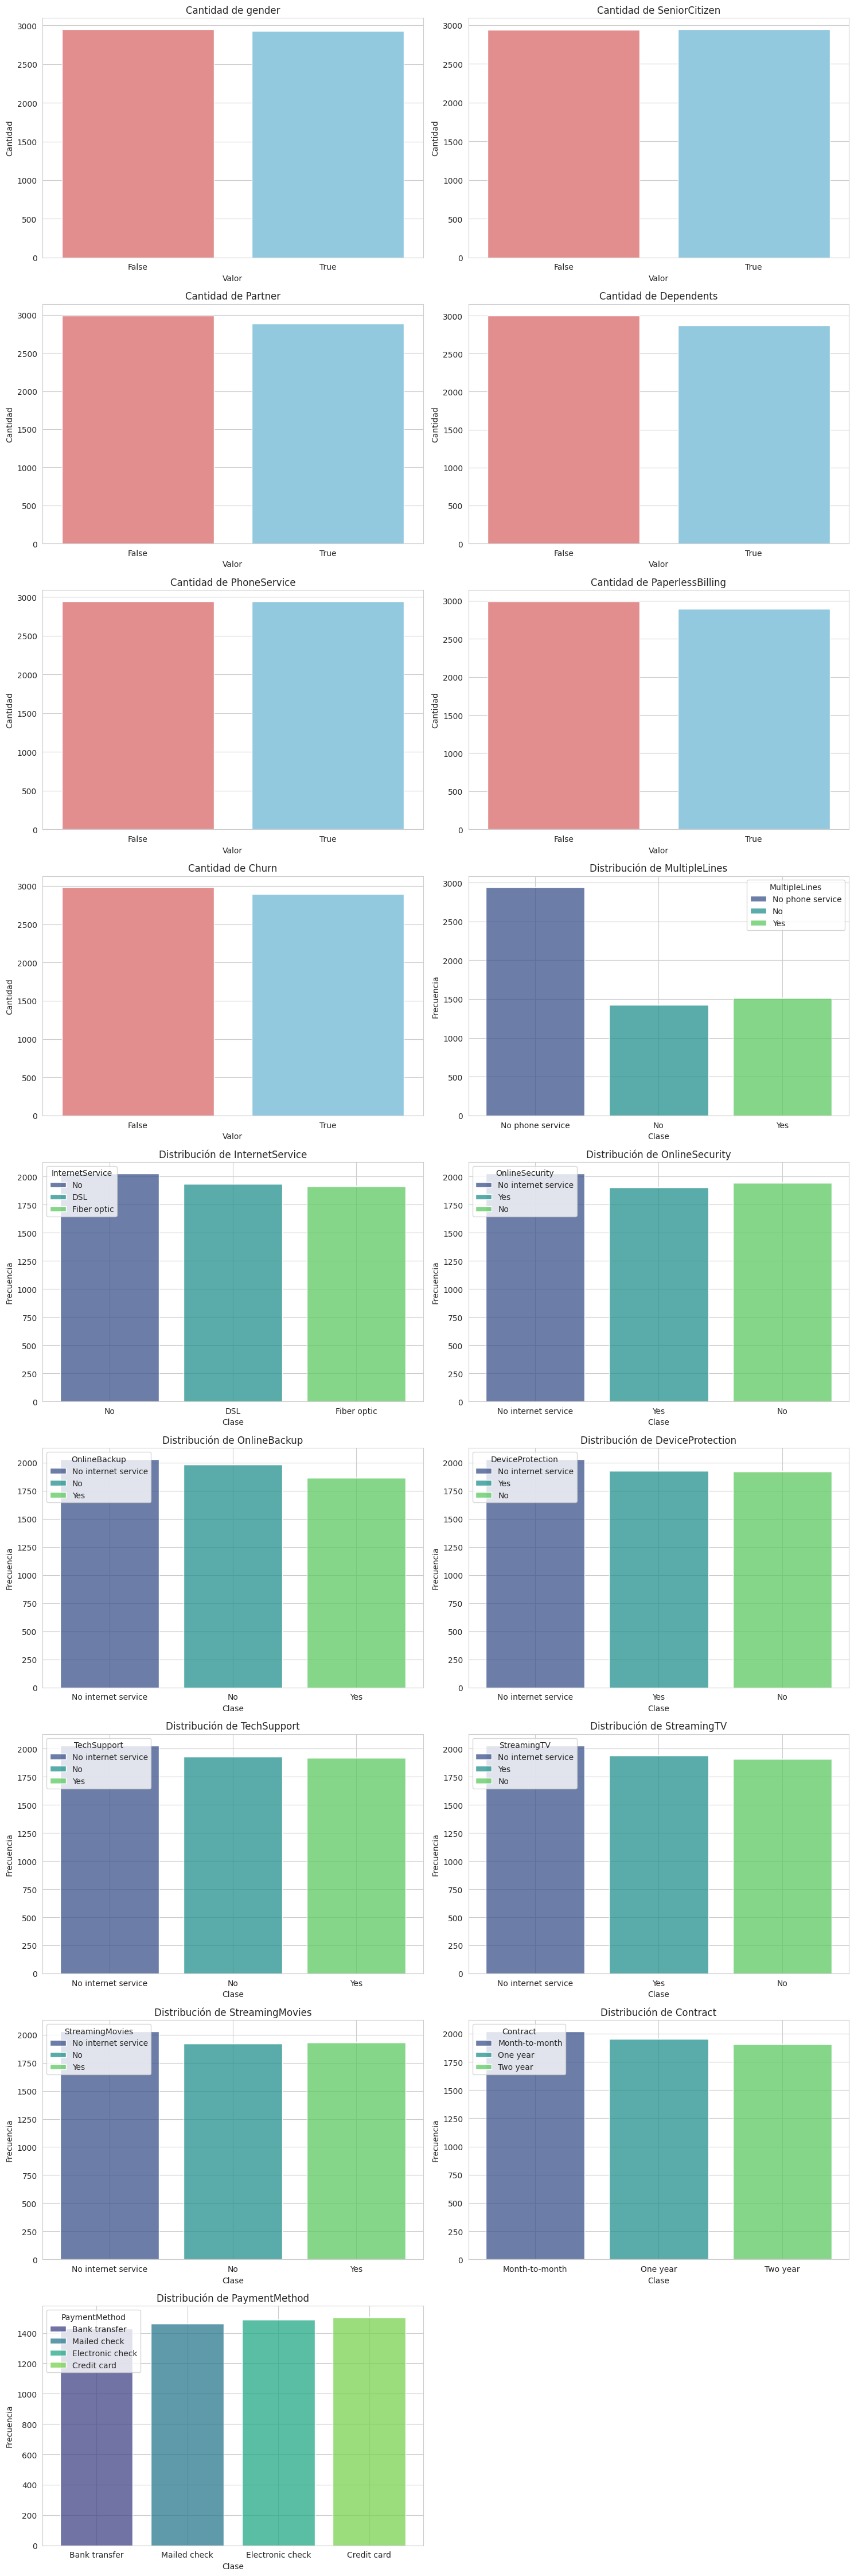

In [48]:
# Definiremos las variables a graficar
binary_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
multi_class_vars = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

# Create subplots
n_cols = 2  # Number of columns for subplots
n_rows = (len(binary_vars) + len(multi_class_vars) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot binary variables
for i, var in enumerate(binary_vars):
    counts = df_churn[var].value_counts()
    sns.barplot(x=counts.index, y=counts.values, palette=['lightcoral', 'skyblue'], ax=axes[i])
    axes[i].set_title(f'Cantidad de {var}')
    axes[i].set_xlabel('Valor')
    axes[i].set_ylabel('Cantidad')
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['False', 'True'])

# Plot multi-class variables with different colors
for i, var in enumerate(multi_class_vars, start=len(binary_vars)):
    sns.histplot(df_churn, x=var, hue=var, multiple='stack', shrink=0.8, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Distribución de {var}')
    axes[i].set_xlabel('Clase')
    axes[i].set_ylabel('Frecuencia')

# Remove any unused subplots
if len(binary_vars) + len(multi_class_vars) < len(axes):
    for j in range(len(binary_vars) + len(multi_class_vars), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Podemos observar que en gran parte de las variables no existe alguna diferencia marcada en la distribución de los campos, salvo en la variable MultipleLines donde observamos que aproximadamente un 50% del dataset no tiene servicio telefónico.

# 4. Data Wrangling

Como se mencionó anteriormente el dataset escogido se compone mayoritariamente de variables categóricas, las que debemos transformar en variables numéricas para responder nuestras preguntas. Primero identificamos las variables categóricas, previamente estudiadas, esto para facilitar su incorporación al paso siguiente.

Debemos recordar que el Data Wrangling de este proyecto se limitará a esta transformación de variables, debido a que en el primer paso se demostró que la completitud del dataset es al 100%, motivo por el cuál no será necesario realizar métodos de imputación

In [49]:
categorical_columns = df_churn.select_dtypes(include=['object']).columns.tolist()
print(categorical_columns)

['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


No consideraremos la variable customerID ya que es considerada una variable de identificación o referencia de fila, esto se debe a que no se poseen mayores antecedentes y se desconoce si este ID de cliente pudiera tener alguna estructura en particular que pudiera afectar el churn, por lo tanto no será considerado como una variable a estudiar en este proyecto.

In [50]:
categorical_columns = [col for col in categorical_columns if col != 'customerID']
print(categorical_columns)

['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [51]:
label_encoders = {}
value_mappings = {}

for col in categorical_columns:
    label_encoder = LabelEncoder()
    df_churn[col] = label_encoder.fit_transform(df_churn[col])
    label_encoders[col] = label_encoder
    value_mappings[col] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))


A modo de buenas prácticas haremos una revisión de existencia de valores nulls, ya que en caso de existir previamente el EDA debiéramos rellenar o quitar bajo algún método de imputación.

In [52]:
df_churn.isnull().values.any()


False

Este simple test nos ayuda a comprobar la existencia de valores nulls en el dataset, al ser False indica que la dimensión de calidad de completitud es 100%

In [53]:
# Identificamos las propiedades mapeadas con LabelEncoder
for col, mapping in value_mappings.items():
    print(f"Mapeo de la columna {col}: {mapping}")

Mapeo de la columna gender: {'Female': 0, 'Male': 1}
Mapeo de la columna Partner: {'No': 0, 'Yes': 1}
Mapeo de la columna Dependents: {'No': 0, 'Yes': 1}
Mapeo de la columna PhoneService: {'No': 0, 'Yes': 1}
Mapeo de la columna MultipleLines: {'No': 0, 'No phone service': 1, 'Yes': 2}
Mapeo de la columna InternetService: {'DSL': 0, 'Fiber optic': 1, 'No': 2}
Mapeo de la columna OnlineSecurity: {'No': 0, 'No internet service': 1, 'Yes': 2}
Mapeo de la columna OnlineBackup: {'No': 0, 'No internet service': 1, 'Yes': 2}
Mapeo de la columna DeviceProtection: {'No': 0, 'No internet service': 1, 'Yes': 2}
Mapeo de la columna TechSupport: {'No': 0, 'No internet service': 1, 'Yes': 2}
Mapeo de la columna StreamingTV: {'No': 0, 'No internet service': 1, 'Yes': 2}
Mapeo de la columna StreamingMovies: {'No': 0, 'No internet service': 1, 'Yes': 2}
Mapeo de la columna Contract: {'Month-to-month': 0, 'One year': 1, 'Two year': 2}
Mapeo de la columna PaperlessBilling: {'No': 0, 'Yes': 1}
Mapeo de la 

In [54]:
df_churn.describe()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_zscore
count,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,...,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5880.000000,5.880000e+03
mean,0.501701,0.500680,0.509354,0.489116,36.549150,0.500170,1.014116,1.015816,0.992687,0.979422,...,0.997789,1.005612,1.001871,0.980612,0.491497,1.507653,70.157779,2566.813165,0.492857,5.558668e-17
std,0.500040,0.500042,0.499955,0.499924,20.909674,0.500042,0.707146,0.821087,0.809314,0.809086,...,0.809344,0.809328,0.809345,0.816961,0.499970,1.110317,28.804615,1910.017743,0.499991,1.000000e+00
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,20.030000,0.000000,-1.333382e+00
25%,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,45.717500,1020.217500,0.000000,-8.097284e-01
50%,1.000000,1.000000,1.000000,0.000000,37.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.000000,2.000000,70.155000,2136.445000,0.000000,-2.253216e-01
75%,1.000000,1.000000,1.000000,1.000000,55.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,95.457500,3767.665000,1.000000,6.287124e-01
max,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,119.990000,8589.600000,1.000000,3.153262e+00


Ahora que transformamos nuestra variables binarias y multiclase en tipo numérico, podemos incluir estas en la matriz de correlación que queremos utilizar para ayudarnos a responder en parte la hipóteis planteada.

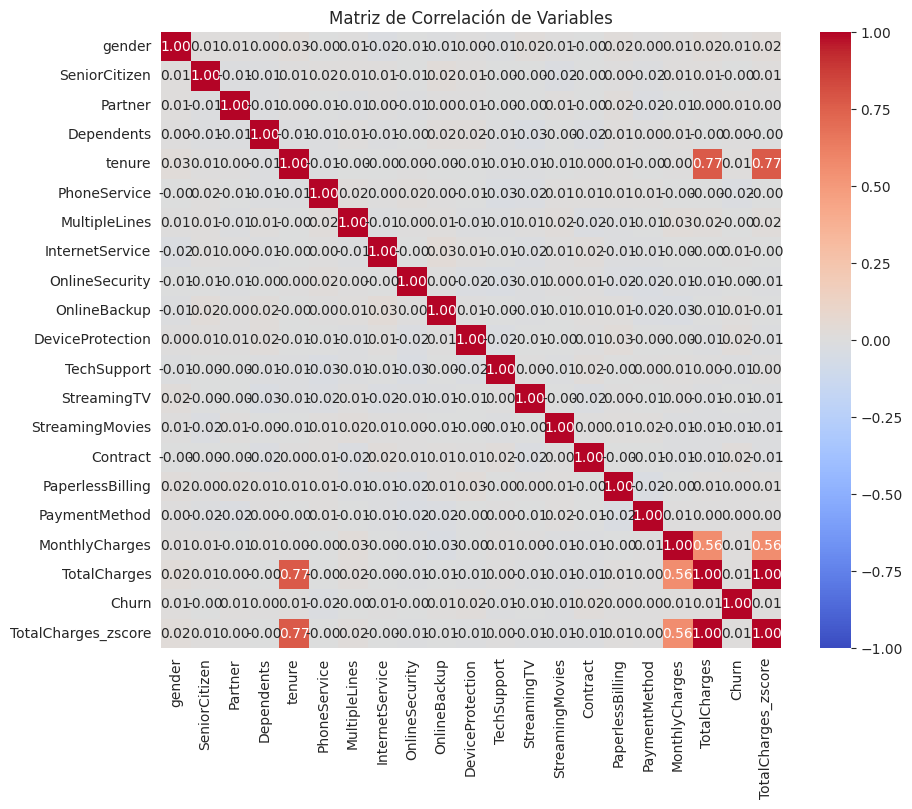

In [55]:
#Utilizaremos el método de correlación de pearson para una visualización simple de estas mismas

numeric_columns = df_churn.select_dtypes(include=['float64', 'int64']).columns

# Calcula la matriz de correlación solo para las columnas numéricas
correlation_matrix = df_churn[numeric_columns].corr()

# Genera un mapa de calor de la matriz de correlación usando Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Variables')
plt.show()

En primer lugar, vemos que casi ninguna variable se encuentra altamente correlacionada ni positiva ni negativamente, exceptuando las variables tenure, MonthlyCharge y TotalCharges, lo que es esperable debido a la explicación que se mencionó con anterioridad en el Scater Plot de la variable TotalCharges.

Podemos observar que ninguna de las variables del dataset pareciera ser influyente sobre la variable en estudio "Churn", sin embargo, aún no se puede descartar la H0 planteada debido a que debmos realizar un test estadístico para probar esto mismo.

Ahora mediremos el equilibrio de la clase para la variable Churn

In [56]:
class_distribution = df_churn['Churn'].value_counts(normalize=True)
print(class_distribution)

Churn
0    0.507143
1    0.492857
Name: proportion, dtype: float64


Vemos que la variable a predecir tiene una distribución bastante pareja, lo que ya probamos anteriormente dentro del EDA. ¿Qué signfica esto? No será necesario realizar alguna técnica de balanceo en el dataset y que probablemente los resultados del modelo no se inclinen hacia ninguna clase particularmente.

Antes de pasar al modelado, haremos el drop de la variable ID, ya que al ser un identificador no aportará al modelo, esto es debido a que no tenemos mayor información de sobre si este identificador se relaciona con algo.

In [57]:
df_churn = df_churn.drop(columns=['customerID'])

# 5. Modelado

Ahora que hemos estudiado

In [58]:
# Separamos X e y
X = df_churn.drop(columns=['Churn'])
y = df_churn['Churn']  # Variable objetivo

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Aplicaremos un método de RFE para seleccionar las características más importantes del dataset, de manera tal se puede construir un modelo más simple y preciso. Particularmente utilizaremos este método porque se pensó desde un comienzo en una regresión logística debido a que la variable respuesta es una variable binaria y la función sigmoide debiera facilitar la predicción de esta misma.

In [60]:
# Inicializar el modelo de regresión logística
logreg = LogisticRegression()

# Aplicar RFE
rfe = RFE(logreg, n_features_to_select=10)  # Selecciona el número de características que deseas mantener
rfe = rfe.fit(X_train, y_train)

# Seleccionar las características
X_train_selected = rfe.transform(X_train)
X_test_selected = rfe.transform(X_test)

# Opcional: Ver las características seleccionadas
selected_features = X_train.columns[rfe.support_]
print("Características seleccionadas:", selected_features)


Características seleccionadas: Index(['SeniorCitizen', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'TotalCharges_zscore'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [61]:
# Entrenar el modelo
logreg = LogisticRegression()
logreg.fit(X_train_selected, y_train)

# Predecir y evaluar en el conjunto de prueba
y_pred = logreg.predict(X_test_selected)
y_pred_proba = logreg.predict_proba(X_test_selected)[:,1]

# Evaluación del modelo
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

              precision    recall  f1-score   support

           0       0.49      0.70      0.58       874
           1       0.50      0.30      0.38       890

    accuracy                           0.50      1764
   macro avg       0.50      0.50      0.48      1764
weighted avg       0.50      0.50      0.48      1764

ROC AUC: 0.49960275628005046


Vemos que los resultados del modelo generado son bastante bajos, obteniendo métricas como el f-1 score de 0.58 para el caso negativo y 0.38 para el caso positivo y con un ROC AUC de 0.49

Debido a esto ajustaremos algunos parámetros del modelo utilizado

In [62]:
# Ajuste del umbral
threshold = 0.52
y_pred_adjusted = (logreg.predict_proba(X_test_selected)[:,1] >= threshold).astype(int)
y_pred_adjusted_proba = logreg.predict_proba(X_test_selected)[:,1]

# Evaluación del modelo con el umbral ajustado
print(classification_report(y_test, y_pred_adjusted))
print("ROC AUC:", roc_auc_score(y_test, y_pred_adjusted_proba))


              precision    recall  f1-score   support

           0       0.49      0.88      0.63       874
           1       0.45      0.10      0.16       890

    accuracy                           0.49      1764
   macro avg       0.47      0.49      0.39      1764
weighted avg       0.47      0.49      0.39      1764

ROC AUC: 0.49960275628005046


Debido a que la variable Churn se encuentra bien balanceada, el mover el threshold no afectará de una manera significativa a los resultados del modelo, vemos como el modificar este valor sobre el 0.5 nos genera un cambio demasiado brusco sobre el f1-score

Probaremos con un nuevo modelo, en este caso utilizaremos un random forest

In [63]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_selected, y_train)

RandomForestClassifier(random_state=42)

In [64]:
# Realizar predicciones en el conjunto de prueba
y_pred = rf_model.predict(X_test_selected)
y_pred_proba = rf_model.predict_proba(X_test_selected)[:, 1]

In [65]:
# Generar el reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.53      0.51       874
           1       0.51      0.47      0.49       890

    accuracy                           0.50      1764
   macro avg       0.50      0.50      0.50      1764
weighted avg       0.50      0.50      0.50      1764



Vemos que con random forest el modelo ha logrado mejorar su capacidad de predicción al obtener mejores resultados sobre el predictor positivo (0.49 vs 0.38), pero también el nuevo modelo ha generado una disminución sobre el F-1 score del predictor negativo (0.51 vs 0.58)

Aora visualizaremos la matriz confusión sobre el modelo generado

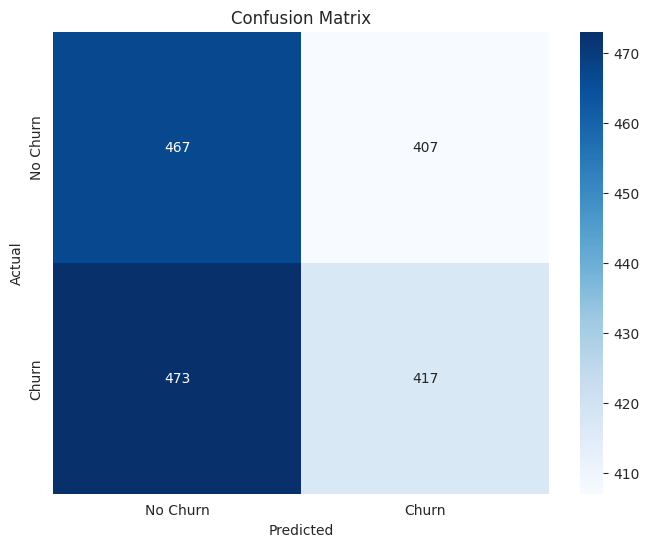

In [66]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Vemos que la predicción es bastante balanceada para los casos clasificados correctamente como para aquellos clasificados de manera incorrecta, lo que va de la mano con los resultados obtenidos en el f-1 score para el modelo analizado.

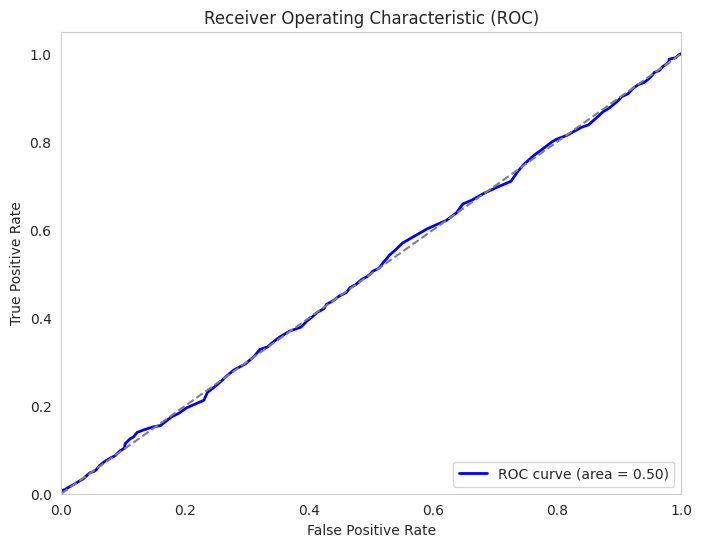

In [67]:
# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular el valor del AUC
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Línea diagonal (clasificador aleatorio)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid()
plt.show()


Al igual que en la revisión anterior buscamos un AUC que se ajuste al estándar de un buen modelo esto es curvo hacia los true positive, sin embargo vemos una recta diagonal, lo que conjunto el test del AUC (0.5) nos permite ver que es un modelo deficiente, dado que sería prácticamente un modelo que está adivinando el resultado, como lanzar una moneda con 50% de probabilidad

# 7. Conclusiones

A modo de conclusión, se rechazaría el uso de los modelos ya que no son útiles o bien no tienen buenas métricas, dado que este es un proyecto con motivo académicos se concluirá basado en estos resultados, en un proyecto real se debiera explorar otras opciones o explorar a mayor profundidad las bases de datos utilizadas o inclusive incluir otras bases de datos al tener reuniones con stakeholders o expertos en el dominio.

En primer lugar, se responden las preguntas planteadas al comienzo a lo largo del ejercicio del proyecto, vemos que las variables no tienen una correlación significativa y al generar modelos con resultados bajo lo esperado podríamos decir que las variables utilizadas y escogidas con el RFE no tienen un impacto significativo en el desarrollo del modelo.

¿Qué se sugiere en caso de continuar el estudio?

Como se comentó anteriormente, en un caso real se podrían seguir distintos cursos de acción.
1. Conversar con los expertos en el dominio del problema, entender si es que existen mejores bases de datos para enriquecer el análisis y generar el EDA nuevamente
2. Seguir probando otros modelos que permitan mejorar aún más los resultados, con distintos parámetros, sin embargo, esta opción podría llevarnos a una posible situación de overfitting al forzar tanto la base de datos.
3. Solicitar una mayor cantidad de registros. Si vemos la base tiene un poco más de 5.000 registros lo que en muchos casos se consideraría una cantidad baja de datos.
4. Modificar el enfoque del proyecto, dado que no se llega a un modelo relevante, se podría modificar el enfoque del proyecto tal vez a clasificar o clusterizar los clientes, pensando en una posible segmentación de clientes.
5. La última opción y que personalmente no la considero tan recomendada (dado que el churn es uno de los principales problemas en empresas de recurrencia) es cancelar el proyecto y enfocarse en un problema tanto o más relevante para la compañía hasta que se generen mejores datos para el desarrollo del modelo, por ejemplo motivos de churn, identificación de clientes churneados morosos, etc.

Finalmente, señalar que el proyecto cumple los objetivos planteados al comienzo de este mismo.